In [1]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32,

)


Found 4752 files belonging to 9 classes.


In [4]:
class_names = sorted(os.listdir(data_path))  # Get folder names
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [5]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.4),         # Randomly rotate images by up to 20%
    RandomZoom(0.4),             # Randomly zoom into images by 20%
    RandomBrightness(factor=0.4),        # Randomly increase the brightness
    RandomCrop(150,160)
])


# Apply augmentation to the training data
def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



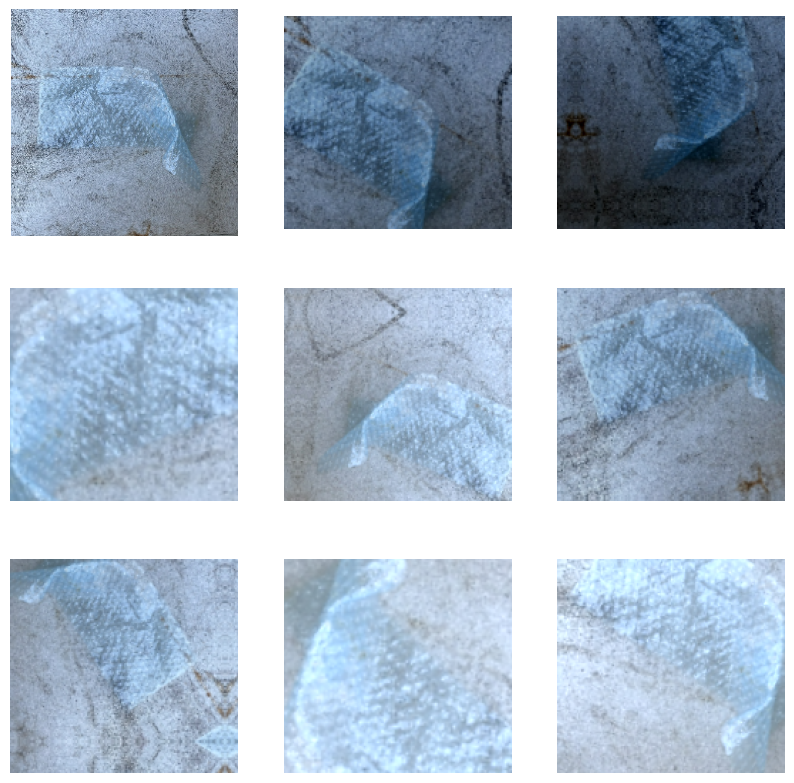

In [6]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]  # Select the first image in the batch

        # Apply augmentation multiple times to the same image
    augmented_images = [image]
    for _ in range(8):  # Create 8 augmented versions
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])

        # Display the original and augmented images
    for i in range(9):  # Display 9 images (1 original + 8 augmented)
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")

    plt.show()

# Call the function to visualize data augmentation
visualize_dataset(dataset, class_names)

In [7]:
def normalize_img(image, label):
    image = image/ 255.0  # Scale pixel values to [0, 1]
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label




In [8]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [9]:
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

train_dataset = dataset.take(train_size).map(augment).map(normalize_img)

val_dataset = dataset.skip(train_size).take(val_size).map(normalize_img)
test_dataset = dataset.skip(train_size + val_size).map(normalize_img)

In [10]:
for images, labels in train_dataset.take(1):
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")

Min pixel value: 0.0
Max pixel value: 1.0


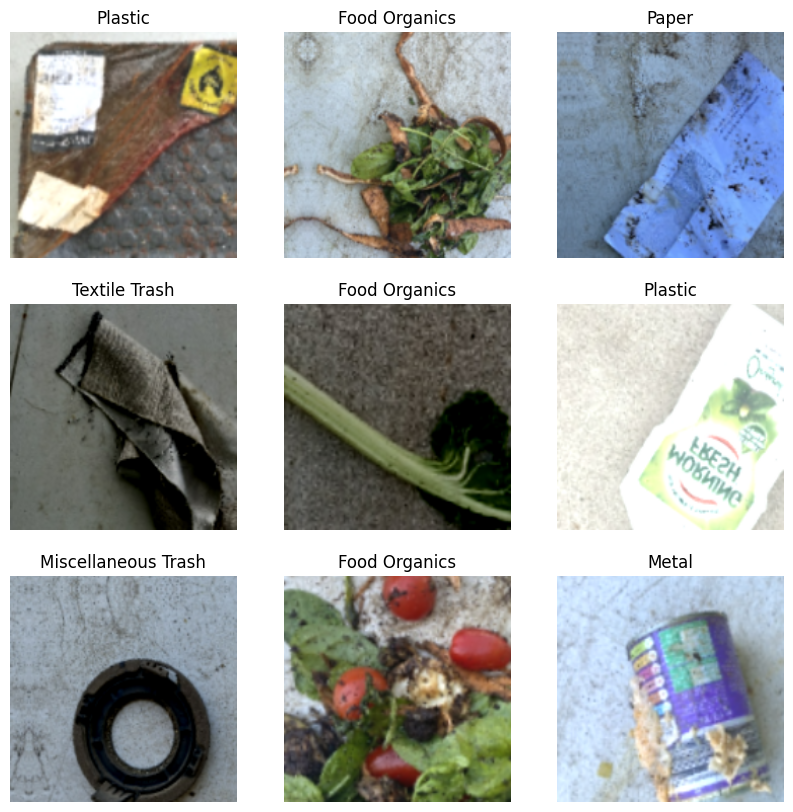

In [11]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(9):  # Show 9 images
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            plt.imshow(img)
            label_idx = tf.argmax(labels[i]).numpy()  # Extract class index from one-hot label
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.show()

# Visualize data augmentation results
visualize_dataset(train_dataset, class_names)

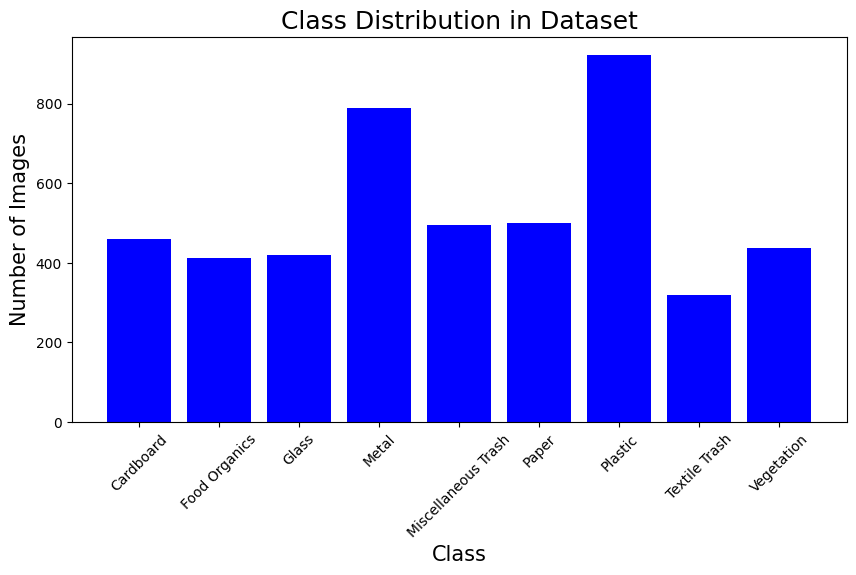

In [12]:


# Count number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [13]:
label_counter = Counter()
for _, label in train_dataset.unbatch().as_numpy_iterator():
    label = np.array(label)
    if label.size == 1:
        label = label.item()
    else:
        label = int(np.argmax(label))
    label_counter[int(label)] += 1

# Step 4: Identify underrepresented classes (e.g., below median)
counts = np.array(list(label_counter.values()))
median_count = np.median(counts)
low_classes = [cls for cls, count in label_counter.items() if count < median_count]
low_class_tensor = tf.constant(low_classes, dtype=tf.int64)
print("Low-frequency classes:", low_classes)

def is_low_class(image, label):
    label = tf.cast(tf.argmax(label, axis=-1), tf.int64)
    return tf.reduce_any(tf.equal(label, low_class_tensor))

def extra_augment(image, label):
    image = tf.image.rot90(image)
    image = tf.image.random_saturation(image, 0.6, 1.4)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.cast(label, tf.int32), 9)
    return image, label

low_class_augmented = train_dataset.unbatch().filter(is_low_class).map(extra_augment).map(normalize_img).repeat(3).batch(32)

# Step 6: Combine both into final training set


final_train_dataset = train_dataset.concatenate(low_class_augmented).unbatch().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


Low-frequency classes: [2, 1, 8, 7]


In [14]:
print("Class distribution after final augmentation:")
label_counter = Counter()

for _, labels in final_train_dataset.unbatch().take(1000):
    label = labels.numpy()
    if label.shape == (9,):  # one-hot
        label_idx = np.argmax(label)
        label_counter[int(label_idx)] += 1

print(dict(label_counter))



Class distribution after final augmentation:
{3: 167, 7: 70, 4: 101, 1: 92, 6: 190, 2: 80, 5: 104, 8: 80, 0: 116}


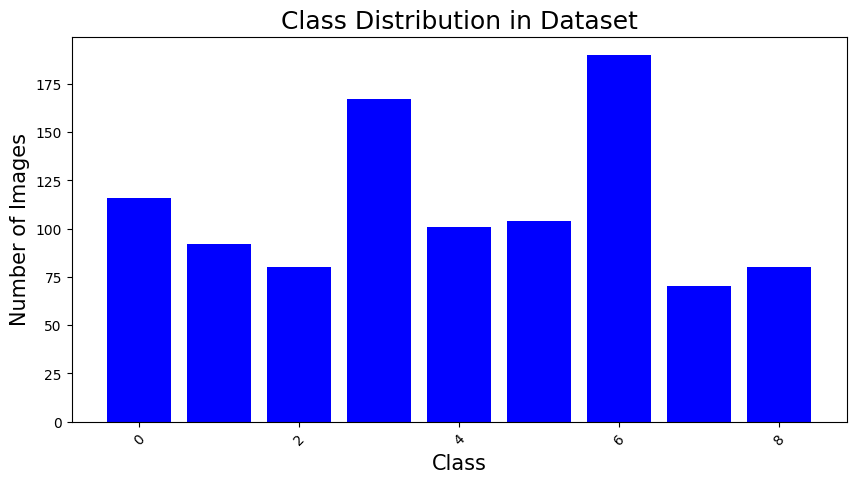

In [15]:


# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counter.keys(), label_counter.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [16]:
# Class weights computation
train_labels = []
for _, label in final_train_dataset.unbatch().take(1000):  # Limit for speed/safety
    label = label.numpy()
    while label.ndim > 1:
        label = np.mean(label, axis=0)
    if label.ndim == 1 and label.shape[0] == 9:
        class_idx = int(np.argmax(label))
        train_labels.append(class_idx)

train_labels = np.array(train_labels)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.arange(9), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.0384215991692627), 1: np.float64(1.1574074074074074), 2: np.float64(1.221001221001221), 3: np.float64(0.6459948320413437), 4: np.float64(1.1337868480725624), 5: np.float64(1.145475372279496), 6: np.float64(0.607164541590771), 7: np.float64(1.5432098765432098), 8: np.float64(1.3227513227513228)}


In [17]:

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for multi-class classification with one-hot labels.
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return loss

In [18]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model



# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")  # Adjust for the number of classes
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=categorical_focal_loss(gamma=2.0, alpha=0.25),
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",  # Monitor the validation loss
                               patience=3,  # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best model weights when stopping
                               verbose=1)  # Print messages when stopping

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weights_dict, callbacks=[early_stopping])



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.1149 - loss: 0.4857 - val_accuracy: 0.0909 - val_loss: 0.4399
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.1182 - loss: 0.4764 - val_accuracy: 0.1065 - val_loss: 0.4365
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 116s 878ms/step - accuracy: 0.1166 - loss: 0.4729 - val_accuracy: 0.0923 - val_loss: 0.4380
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 122s 683ms/step - accuracy: 0.1294 - loss: 0.4678 - val_accuracy: 0.1023 - val_loss: 0.4361
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 69s 660ms/step - accuracy: 0.1070 - loss: 0.4683 - val_accuracy: 0.0710 - val_loss: 0.4353
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 668ms/step - accuracy: 0.1168 - loss: 0.4632 - val_accuracy: 0.0909 - val_loss: 0.4359
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 675ms/step - accuracy: 0.1224 - loss: 0.4716 - val_accuracy: 0.1165 - val_loss: 0.4342
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━

In [28]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.44      0.48        59
           1       0.49      0.46      0.47        57
           2       0.32      0.14      0.19        58
           3       0.52      0.53      0.52       120
           4       0.27      0.30      0.28        70
           5       0.46      0.58      0.51        81
           6       0.45      0.12      0.19       129
           7       0.39      0.66      0.49        59
           8       0.44      0.86      0.58        71

    accuracy                           0.43       704
   macro avg       0.43      0.45      0.41       704
weighted avg       0.44      0.43      0.40       704



In [33]:
# Fine-tuning (optional)
base_model.trainable = True
for layer in base_model.layers[:20]:  # Freeze first 100 layers
    layer.trainable = True

# Recompile after unfreezing
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=["accuracy"])

# Train again on the small batch
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weights_dict, )

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 174s 920ms/step - accuracy: 0.5173 - loss: 1.2781 - val_accuracy: 0.4943 - val_loss: 1.4175
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 698ms/step - accuracy: 0.5456 - loss: 1.2376 - val_accuracy: 0.3878 - val_loss: 1.6663
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 710ms/step - accuracy: 0.5691 - loss: 1.2241 - val_accuracy: 0.4716 - val_loss: 1.4697
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 81s 705ms/step - accuracy: 0.5711 - loss: 1.1862 - val_accuracy: 0.4659 - val_loss: 1.4784
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 72s 685ms/step - accuracy: 0.5640 - loss: 1.1900 - val_accuracy: 0.5185 - val_loss: 1.3224
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 699ms/step - accuracy: 0.5964 - loss: 1.0834 - val_accuracy: 0.4759 - val_loss: 1.5833
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 699ms/step - accuracy: 0.5970 - loss: 1.0889 - val_accuracy: 0.5241 - val_loss: 1.3429
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 699ms/step - accuracy: 0.6071 - loss: 

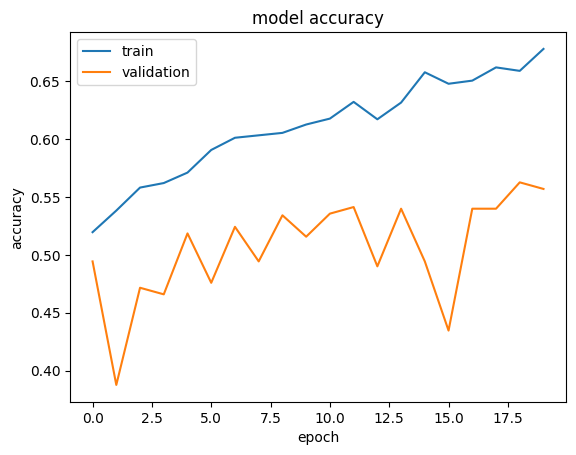

In [34]:
def plot_hist(history_fine_tune):
    plt.plot(history_fine_tune.history["accuracy"])
    plt.plot(history_fine_tune.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_fine_tune)

In [35]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [36]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.67      0.56        60
           1       0.54      0.74      0.62        58
           2       0.54      0.29      0.38        66
           3       0.66      0.67      0.66       123
           4       0.37      0.46      0.41        69
           5       0.59      0.81      0.68        79
           6       0.68      0.22      0.33       129
           7       0.62      0.58      0.60        55
           8       0.69      0.97      0.81        65

    accuracy                           0.57       704
   macro avg       0.57      0.60      0.56       704
weighted avg       0.59      0.57      0.55       704



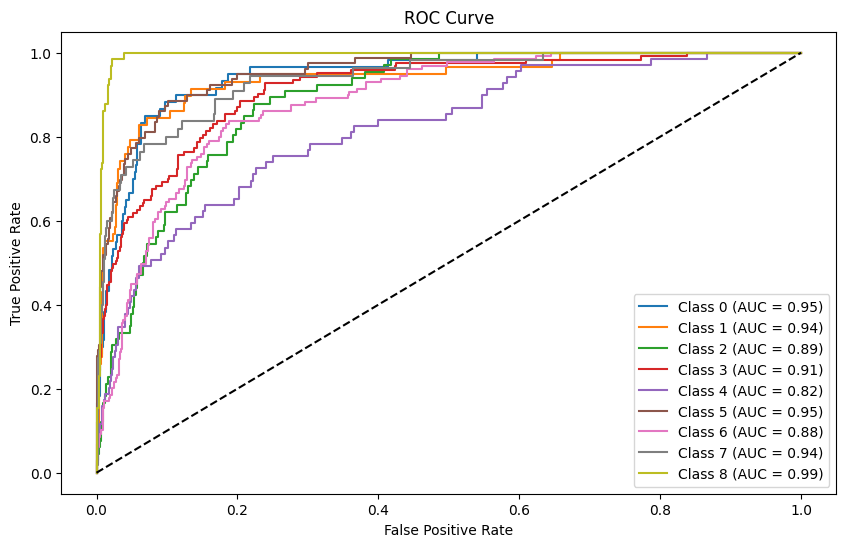

In [37]:

# Convert true labels to one-hot encoding
num_classes = 9  # Adjust to your number of classes
y_true_one_hot = to_categorical(y_true, num_classes)

# Plot ROC Curve for each class
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

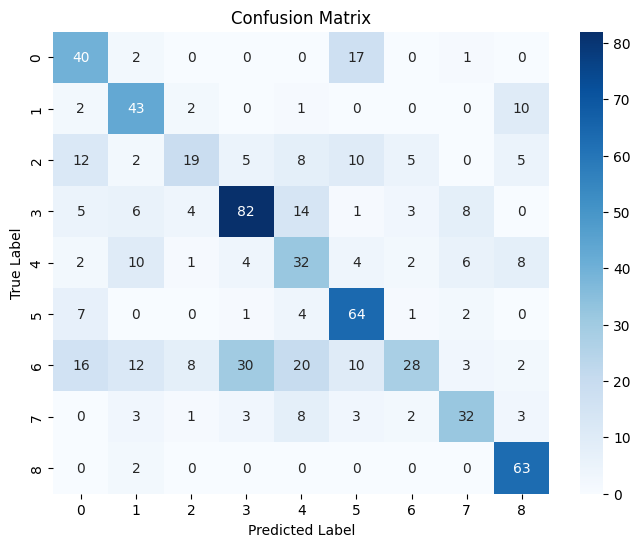

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [27]:
# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


17/23 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.4394 - loss: 0.2615

KeyboardInterrupt: 